# Let's think about fines storage.  
Amanda Manaster  
*2019.06.13*  

**Condition 1:**  
Amount of entering sediment is *greater than* amount of exiting sediment.  

$dS_{f_{i}} = u*n*L - q_s*t_s$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  


**Condition 2:**  
Amount of entering sediment is *less than* amount of exiting sediment.  

$q_{s_{out}} = min(u*n*L + S_{f_i}, q_s*t_s)$  
$ dS_{f_i} = u*n*L - q_{s_{out}}$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  



**where:**  
    &emsp;$S_f$ = storage of fine sediment in $m^2$  
    &emsp;$u$ = pumping of fines w/ each truck pass; $0.05 mm$  
    &emsp;$n$ = # of truck passes; constant   
    &emsp;$L$ = representative length of road in $m$  
    &emsp;$t_s$ = storm duration in $s$  
    &emsp;$q_s$ = mean rate of sediment transport during a storm, assuming steady-state runoff in $m^2/s$   
    
       
**Gover's equation (Istanbulluoglu et al. 2003):**  
    &emsp;$q_s = \frac{10^{-4.348}}{(\rho_s*d_{50}^{0.811})}*(\tau-\tau_c)^{2.457}$  
    
    *Note: This equation is calibrated for sediments that are between 0.058 and 1.098 mm.*  

**more variables:**  
    &emsp;$\tau$ = shear stress; $\rho_w*g*H*S$  
    &emsp;$\tau_c$ = critical shear stress  
    &emsp;$\rho_w$ = density of water; $1000 kg/m^3$  
    &emsp;$g$ = gravity; $9.81 m/s^2$  
    &emsp;$H$ = depth of water; $r*t_s$  
    &emsp;$S$ = slope  
    &emsp;$\rho_s$ = density of sediment; $2650 kg/m^3$  
    &emsp;$r$ = runoff rate in $m/s$  
    &emsp;$d_{50}$ = median grain size of fines  
   

First, we'll import the necessary Python packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

Then, we'll initialize constants and empty lists.

In [2]:
L = 3.66
time = 0 
n = 0
r = 0
month = []
H = []
t = []
len_s = []
truck_pass = []

model_end = 4320 #hours

Now we can run our model. We calculate a "recovery" time, $T_b$, (i.e., the time between two storms) and a "storm" time, $T_r$, (i.e., the length of a storm.) $T_b$ is randomly generated from a uniform distribution spanning 12 to 240 hours. $T_r$ is randomly generated from an exponential distribution centered around 1.7 hours which is the average length of a storm in the PNW assuming:  

$\bar{T_r} = \frac{\bar{P}}{n_s * \bar{i}}$  

where:  
&emsp;$\bar{P} = 2540$ mm  
&emsp;$n_s = 100$ storms  
&emsp;$\bar{i} = 15$ mm/hr  

The model time step is $T_b + T_r$ which causes the time step to change during each loop.

Additionally, a rainfall intensity, $r$, is randomly sampled from a uniform distribution spanning 10 to 25 mm/hr, and each loop of the model appends a constant number of truck passes to an originally empty list.

In [3]:
while time < model_end:
    T_b = np.random.uniform(12,240)
    T_r = np.random.exponential(1.7)
    r = np.random.uniform(10,25)
    n = 50
    
    len_s.append(T_r)
    H.append(T_r*r)
    t.append(time)
    truck_pass.append(n)
    
    time += T_b + T_r

Because we have so many lists/arrays to work with, I create a Pandas dataframe for future calculations and visualizations with these data.

In [4]:
df = pd.DataFrame()

df['time'] = t
df['day'] = np.divide(t,24).astype('int64')
df['storm_depth'] = H
df['storm_length'] = len_s
df['truck_pass'] = truck_pass

day0 = datetime(2018, 10, 1)
df.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df.time]), inplace=True)

df.head()

,time,day,water_depth,storm_length,truck_pass
2018-10-01 00:00:00.000000,0.000000,0,17.597087,1.074950,50
2018-10-07 01:41:49.346532,145.697041,6,4.926608,0.446135,50
2018-10-15 08:24:18.204903,344.405057,14,69.522045,4.680692,50
2018-10-16 15:29:13.609879,375.487114,15,23.505250,0.958817,50
2018-10-25 14:22:16.827451,590.371341,24,27.009827,1.487317,50


As discussed above, the model time step is variable. In order to have a daily time step instead, we resample the Pandas dataframe and give it a new name.

In [5]:
df2 = df.resample('D').mean().fillna(0)
df2['day'] = np.arange(0, len(df2), 1)
df2.head()

,time,day,water_depth,storm_length,truck_pass
2018-10-01,0.0,0,17.597087,1.07495,50.0
2018-10-02,0.0,1,0.000000,0.00000,0.0
2018-10-03,0.0,2,0.000000,0.00000,0.0
2018-10-04,0.0,3,0.000000,0.00000,0.0
2018-10-05,0.0,4,0.000000,0.00000,0.0


Now, we can plot storm depth as a function of time for the entire 6 month time period.

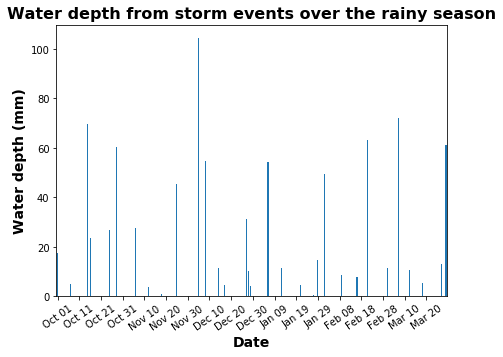

In [6]:
ticklabels = [item.strftime('%b %d') for item in df2.index[::10]]
fig, ax = plt.subplots(figsize=(7,5))
df2.plot.bar(y='water_depth', ax=ax, legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel('Water depth (mm)', fontweight='bold', fontsize=14)
plt.title('Water depth from storm events over the rainy season', fontweight='bold', fontsize=16)
plt.xticks(np.arange(0,10*len(ticklabels),10), ticklabels, rotation=35)
plt.show()

We can start to calculate other parameters, including shear stress, sediment transport rate, and, ultimately, the fine sediment storage.

In [7]:
rho_w = 1000 #kg/m^3
rho_s = 2650 #kg/m^3
g = 9.81 #m/s^2
S = 0.058
tau_c = 0.110 #N/m^2; assuming d50 is approx. 0.0625 mm; value from https://pubs.usgs.gov/sir/2008/5093/table7.html
d50 = 6.25e-5 #m
u = 5.0e-5 #m

shear_stress = rho_w*g*(df.water_depth*0.001)*S

In [8]:
df['q_s'] = ((10**(-4.348))/(rho_s*d50**(0.811)))*(shear_stress-tau_c)**(2.457)

df.fillna(0, inplace=True)

df.head()

,time,day,water_depth,storm_length,truck_pass,q_s
2018-10-01 00:00:00.000000,0.000000,0,17.597087,1.074950,50,0.012157
2018-10-07 01:41:49.346532,145.697041,6,4.926608,0.446135,50,0.000496
2018-10-15 08:24:18.204903,344.405057,14,69.522045,4.680692,50,0.362821
2018-10-16 15:29:13.609879,375.487114,15,23.505250,0.958817,50,0.024929
2018-10-25 14:22:16.827451,590.371341,24,27.009827,1.487317,50,0.035168


In [9]:
df3 = df.resample('D').mean().fillna(0)
df3['day'] = np.arange(0, len(df3), 1)
df3.head()

,time,day,water_depth,storm_length,truck_pass,q_s
2018-10-01,0.0,0,17.597087,1.07495,50.0,0.012157
2018-10-02,0.0,1,0.000000,0.00000,0.0,0.000000
2018-10-03,0.0,2,0.000000,0.00000,0.0,0.000000
2018-10-04,0.0,3,0.000000,0.00000,0.0,0.000000
2018-10-05,0.0,4,0.000000,0.00000,0.0,0.000000


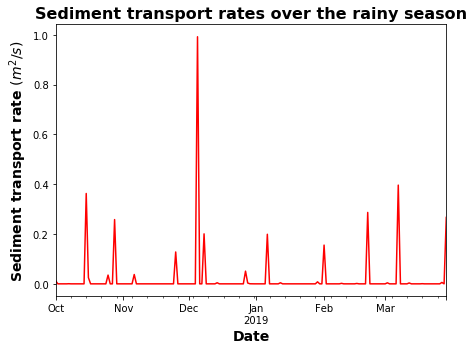

In [10]:
fig2, ax2 = plt.subplots(figsize=(7,5))
df3.plot(y='q_s', ax=ax2, color = 'r', legend=False)
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel(r'Sediment transport rate $(m^2/s)$', fontweight='bold', fontsize=14)
plt.title('Sediment transport rates over the rainy season', fontweight='bold', fontsize=16)
plt.show()

**Condition 1:**  
Amount of entering sediment is *greater than* amount of exiting sediment.  

$dS_{f_{i}} = u*n*L - q_s*t_s$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  


**Condition 2:**  
Amount of entering sediment is *less than* amount of exiting sediment.  

$q_{s_{out}} = min(u*n*L + S_{f_i}, q_s*t_s)$  
$ dS_{f_i} = u*n*L - q_{s_{out}}$  
$S_{f_{i+1}} = S_{f_{i}} + dS_{f_{i}}$  

In [11]:
#Create loop that goes through model time
# 1. Create storage term == 0 at t = 0
# 2. Is avail_sed > sed_transp?
#    - if yes, condition 1 applies
#    - if no, condition 2 applies
# 3. Update storage term according to each condition

In [19]:
exit_sed = df.storm_length*3600*df.q_s
ent_sed = u*df.truck_pass*L
value = (ent_sed-exit_sed)


df['outgoing'] = exit_sed
df['incoming'] = ent_sed
df['value'] = value
df['condition'] = np.where(df.value > 0, 'Conditon 1', 'Condition 2')
df.head()

ent_sed

2018-10-01 00:00:00.000000    0.00915
2018-10-07 01:41:49.346532    0.00915
2018-10-15 08:24:18.204903    0.00915
2018-10-16 15:29:13.609879    0.00915
2018-10-25 14:22:16.827451    0.00915
2018-10-28 14:43:50.182225    0.00915
2018-11-06 00:27:19.712032    0.00915
2018-11-12 12:12:50.439248    0.00915
2018-11-18 08:05:37.715125    0.00915
2018-11-25 06:38:54.287357    0.00915
2018-12-03 23:15:05.844163    0.00915
2018-12-05 05:47:04.616550    0.00915
2018-12-08 09:11:22.153888    0.00915
2018-12-14 03:31:57.054138    0.00915
2018-12-17 16:15:43.308866    0.00915
2018-12-27 07:23:20.665921    0.00915
2018-12-28 05:04:07.760248    0.00915
2018-12-29 21:13:15.806450    0.00915
2019-01-06 08:53:26.533586    0.00915
2019-01-12 12:27:31.675851    0.00915
2019-01-21 04:42:42.193087    0.00915
2019-01-27 11:22:22.153600    0.00915
2019-01-29 07:36:51.224833    0.00915
2019-02-01 06:24:54.436097    0.00915
2019-02-09 07:11:16.931989    0.00915
2019-02-16 03:14:44.678971    0.00915
2019-02-21 1

In [18]:
df['storage'] = np.zeros(len(df))
dsf = []
leftover = np.zeros(len(df))

for i in range(0, len(df)):
    if df.value[i] < 0:
        if i ==0:
            dsf.append(ent_sed[i] - np.minimum(ent_sed[i], exit_sed[i]))
        else:
            dsf.append(ent_sed[i] - np.minimum(ent_sed[i]+leftover[i-1], exit_sed[i]))
    else:
        dsf.append(value[i])

    if i == 0:
        leftover[i] = dsf[i]
    else:
        leftover[i] = leftover[i-1] + dsf[i]
    
        
df.storage = leftover
df['dsf'] = dsf

df

,time,day,water_depth,storm_length,truck_pass,q_s,outgoing,incoming,value,condition,storage,dsf
2018-10-01 00:00:00.000000,0.000000,0,17.597087,1.074950,50,1.215707e-02,47.045633,0.00915,-47.036483,Condition 2,0.000000e+00,0.000000e+00
2018-10-07 01:41:49.346532,145.697041,6,4.926608,0.446135,50,4.959549e-04,0.796545,0.00915,-0.787395,Condition 2,0.000000e+00,0.000000e+00
2018-10-15 08:24:18.204903,344.405057,14,69.522045,4.680692,50,3.628210e-01,6113.711604,0.00915,-6113.702454,Condition 2,0.000000e+00,0.000000e+00
2018-10-16 15:29:13.609879,375.487114,15,23.505250,0.958817,50,2.492919e-02,86.049061,0.00915,-86.039911,Condition 2,0.000000e+00,0.000000e+00
2018-10-25 14:22:16.827451,590.371341,24,27.009827,1.487317,50,3.516840e-02,188.303681,0.00915,-188.294531,Condition 2,0.000000e+00,0.000000e+00
2018-10-28 14:43:50.182225,662.730606,27,60.542653,4.833715,50,2.580363e-01,4490.186906,0.00915,-4490.177756,Condition 2,0.000000e+00,0.000000e+00
2018-11-06 00:27:19.712032,864.455476,36,27.727303,2.377110,50,3.752552e-02,321.128212,0.00915,-321.119062,Condition 2,0.000000e+00,0.000000e+00
2018-11-12 12:12:50.439248,1020.214011,42,4.022831,0.252889,50,2.946793e-04,0.268276,0.00915,-0.259126,Condition 2,0.000000e+00,0.000000e+00
2018-11-18 08:05:37.715125,1160.093810,48,0.889186,0.050858,50,4.463144e-06,0.000817,0.00915,0.008333,Conditon 1,8.332851e-03,8.332851e-03
2018-11-25 06:38:54.287357,1326.648413,55,45.557288,2.820443,50,1.279698e-01,1299.353791,0.00915,-1299.344641,Condition 2,0.000000e+00,-8.332851e-03
